# PnP CTscan imaging of FASTMRI brain dataset

### Author: M. Ravasi

Welcome to the "Deep Learning in Scientific Inverse Problems" course!

The aim of this fifth notebook is to applying Plug-and-Play Priors to CTscan imaging. We will be using a single brain image from the training dataset (which we will always keep in the testing dataset to provide a fair comparison of different methods). 

The problem that we wish to solve can be expressed as:

$$
\underset{\mathbf{m}} {\mathrm{argmin}} \; \Vert \mathbf{d}- \mathbf{G}\mathbf{m} \Vert_2^2 + \lambda R(\mathbf{m})
$$

where $R$ is an unspecified regularizer whose proximal operation is replaced by a pre-trained denoising network.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import astra
import numpy as np
import matplotlib.pyplot as plt
import pylops
import torch
import torch.nn as nn

from scipy.sparse.linalg import lsqr
from tqdm.notebook import tqdm, trange
from pylops import Identity
from pylops.utils.dottest import dottest
from pylops.utils.metrics import snr
from pyproximal.proximal import *
from pyproximal.optimization.primal import *
from torchinfo import summary

from ct import CT2D
from drunet import UNetRes
from denoising import denoising
from primaldual import PlugAndPlay_PrimalDual, callback
from plotting import plt_comparison

#device = 'cpu'
device = torch.device('cuda:0')

## Load brain image and create CT data

In [2]:
# Load data
brains = np.load('../data/brains_trainingdata.npy')
brain = brains[10]
nx, ny = brain.shape

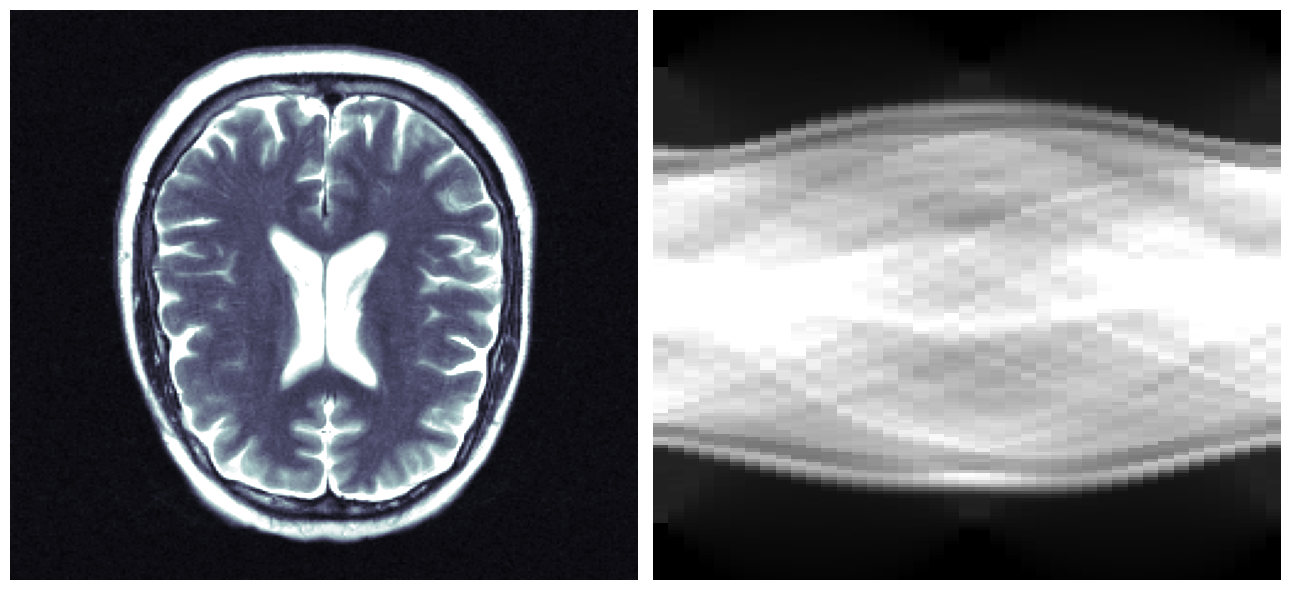

In [3]:
# Create data
nangles = 41
distdetectors = 2
ndetectors = 160

vol_geom = astra.create_vol_geom(nx, ny)
proj_geom = astra.create_proj_geom('parallel', distdetectors, ndetectors, 
                                   np.linspace(0, np.pi, nangles, False))

proj_id = astra.create_projector('strip', proj_geom, vol_geom)
sinogram_id, sinogram = astra.create_sino(brain, proj_id)

fig, axs = plt.subplots(1, 2, figsize=(13, 6))
axs[0].imshow(brain, vmin=0, vmax=.5, cmap='bone')
axs[0].axis('tight')
axs[0].axis('off')
axs[1].imshow(sinogram.T, cmap='gray', vmin=0, vmax=6e1)
axs[1].axis('tight')
axs[1].axis('off')
plt.tight_layout()

In [4]:
# Create operator
Cop = CT2D((nx, ny), distdetectors, ndetectors, np.linspace(0, np.pi, nangles, False))
dottest(Cop, atol=1e-3, verb=True)

Dot test passed, v^H(Opu)=360.79172342505103 - u^H(Op^Hv)=360.79216785473056


True

## Plug-and-Play prior

In [5]:
# Pre-trained DRUNet
drunet = UNetRes(in_nc=2)
drunet.load_state_dict(torch.load('../models/drunet_gray.pth'))
drunet.eval().to(device)
summary(drunet, (1, 2, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
UNetRes                                  [1, 1, 128, 128]          --
├─Conv2d: 1-1                            [1, 64, 128, 128]         1,152
├─Sequential: 1-2                        [1, 128, 64, 64]          --
│    └─ResBlock: 2-1                     [1, 64, 128, 128]         --
│    │    └─Sequential: 3-1              [1, 64, 128, 128]         73,728
│    └─ResBlock: 2-2                     [1, 64, 128, 128]         --
│    │    └─Sequential: 3-2              [1, 64, 128, 128]         73,728
│    └─ResBlock: 2-3                     [1, 64, 128, 128]         --
│    │    └─Sequential: 3-3              [1, 64, 128, 128]         73,728
│    └─ResBlock: 2-4                     [1, 64, 128, 128]         --
│    │    └─Sequential: 3-4              [1, 64, 128, 128]         73,728
│    └─Conv2d: 2-5                       [1, 128, 64, 64]          32,768
├─Sequential: 1-3                        [1, 256, 32, 32]     

/home/ravasim/Documents/2023/Teaching/DA_summerschool_2023/notebooks/plotting.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


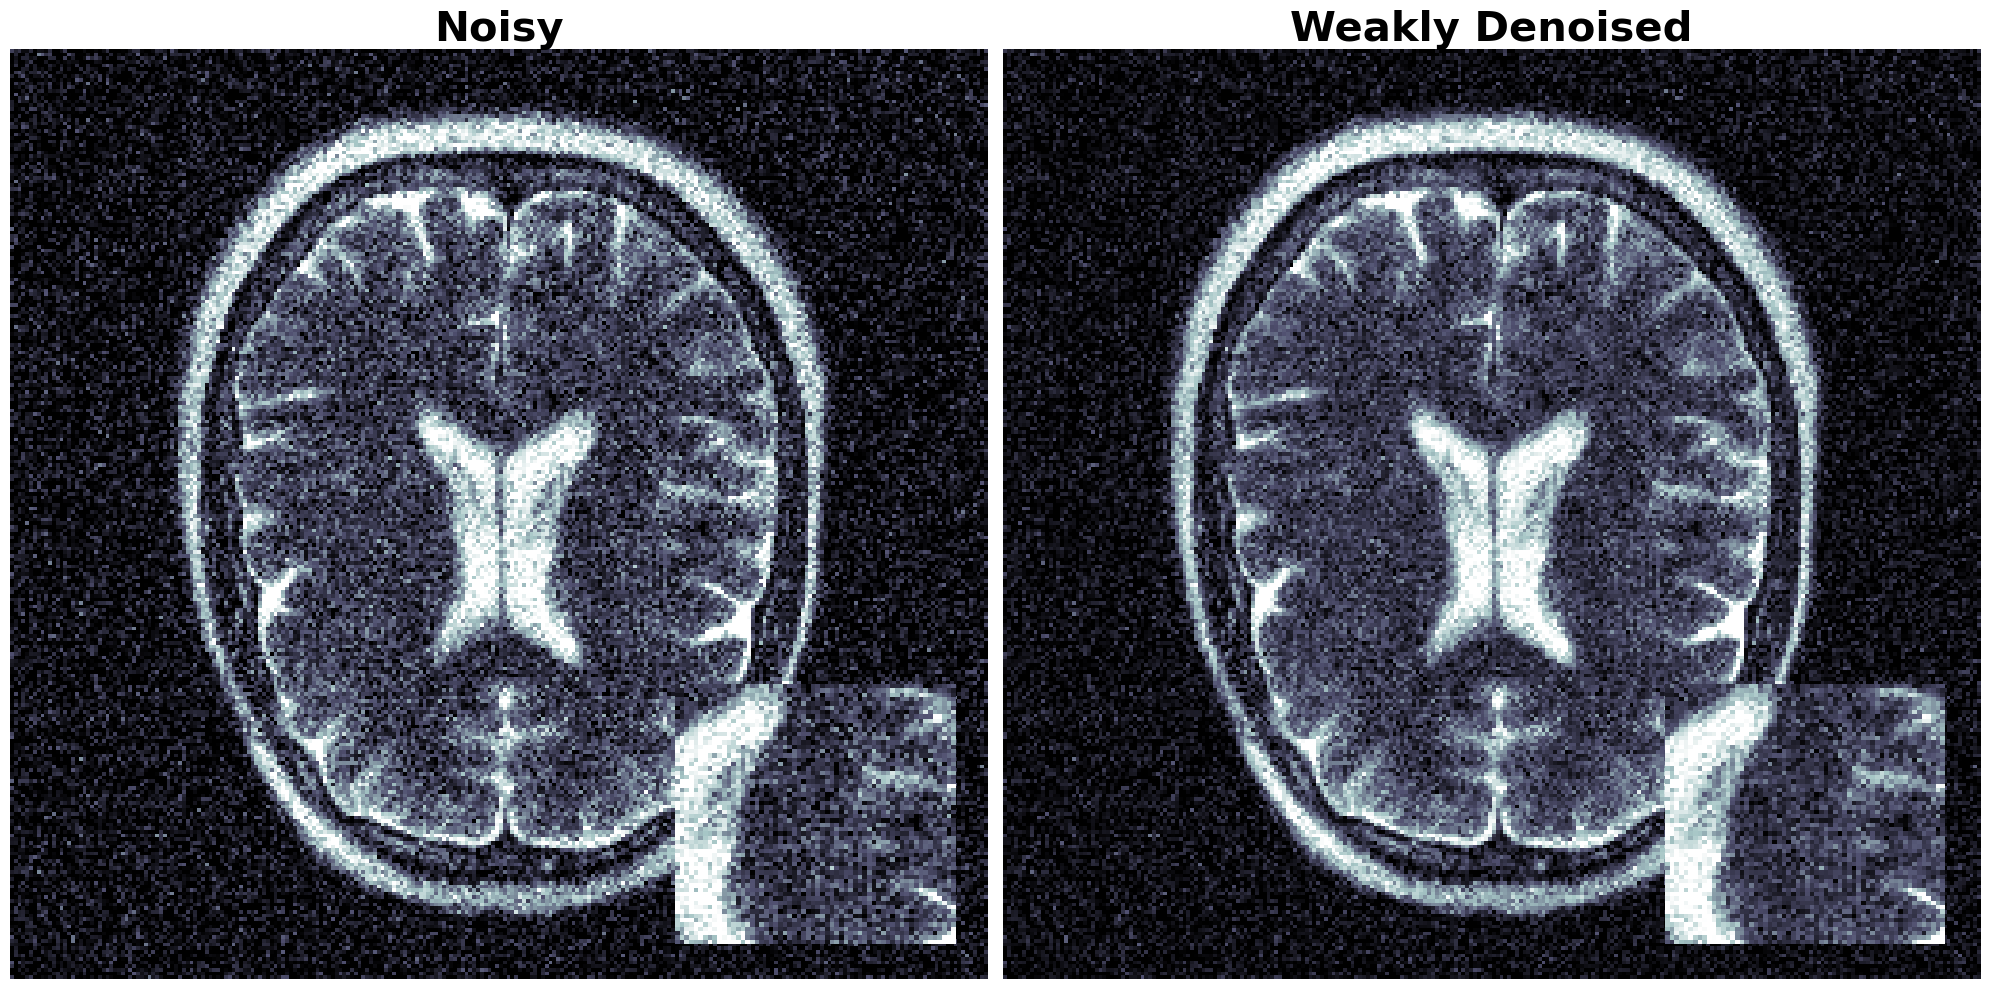

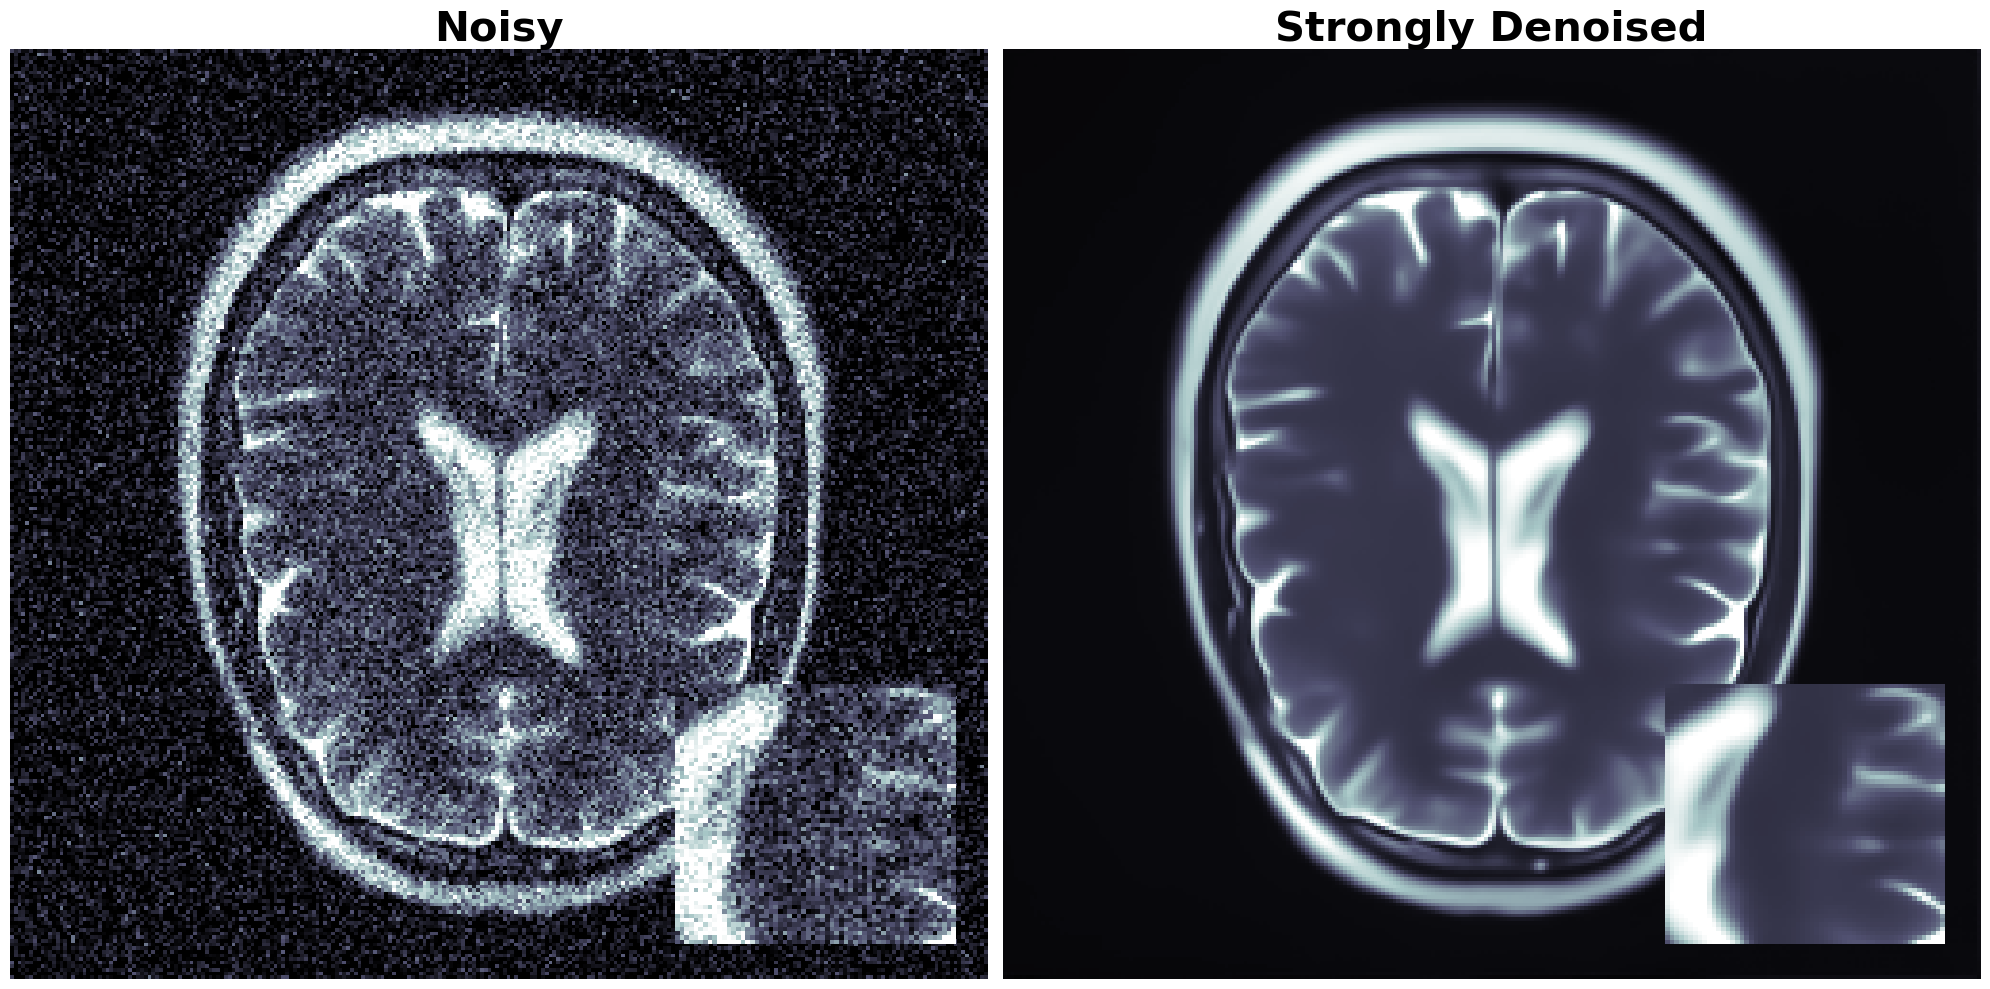

In [6]:
# Test denoiser
drunet.half(); # Make network half precision
denoiser_dn = lambda x, mu: denoising(drunet, torch.from_numpy(x).float(), mu, .001, 
                                      half=True, device=device, verb=False)

brainn = brain + np.random.normal(0, 0.1, (nx, ny))
brainden_weak  = denoiser_dn(brainn, 1)
brainden_strong = denoiser_dn(brainn, 5)

plt_comparison(brainn, brainden_weak, cmap='bone', clim=(0, 0.7), 
               titles=['Noisy', 'Weakly Denoised'], zoom=(100, 160, 130, 190))

plt_comparison(brainn, brainden_strong, cmap='bone', clim=(0, 0.7), 
               titles=['Noisy', 'Strongly Denoised'], zoom=(100, 160, 130, 190))

In [17]:
Iop = Identity(nx*ny)
l2 = L2(Op=Cop, b=sinogram.ravel(), x0=np.zeros(nx*ny), niter=20, warm=True)

# Primal-Dual parameters
tau = .1
mu = .5
sigma = .01 # sigma/mu is the extra channel of DRUNET

drunet.half(); # Make network half precision
denoiser_dn = lambda x, mu: denoising(drunet, torch.from_numpy(x).float(), mu, sigma, 
                                      half=True, device=device, verb=False)

brainpnp = PlugAndPlay_PrimalDual(l2, denoiser_dn, Iop, (nx, ny),
                                  tau=tau, x0=Cop.H @ sinogram.ravel(), mu=mu,
                                  niter=50, show=False)
brainpnp = brainpnp.reshape(nx, ny)

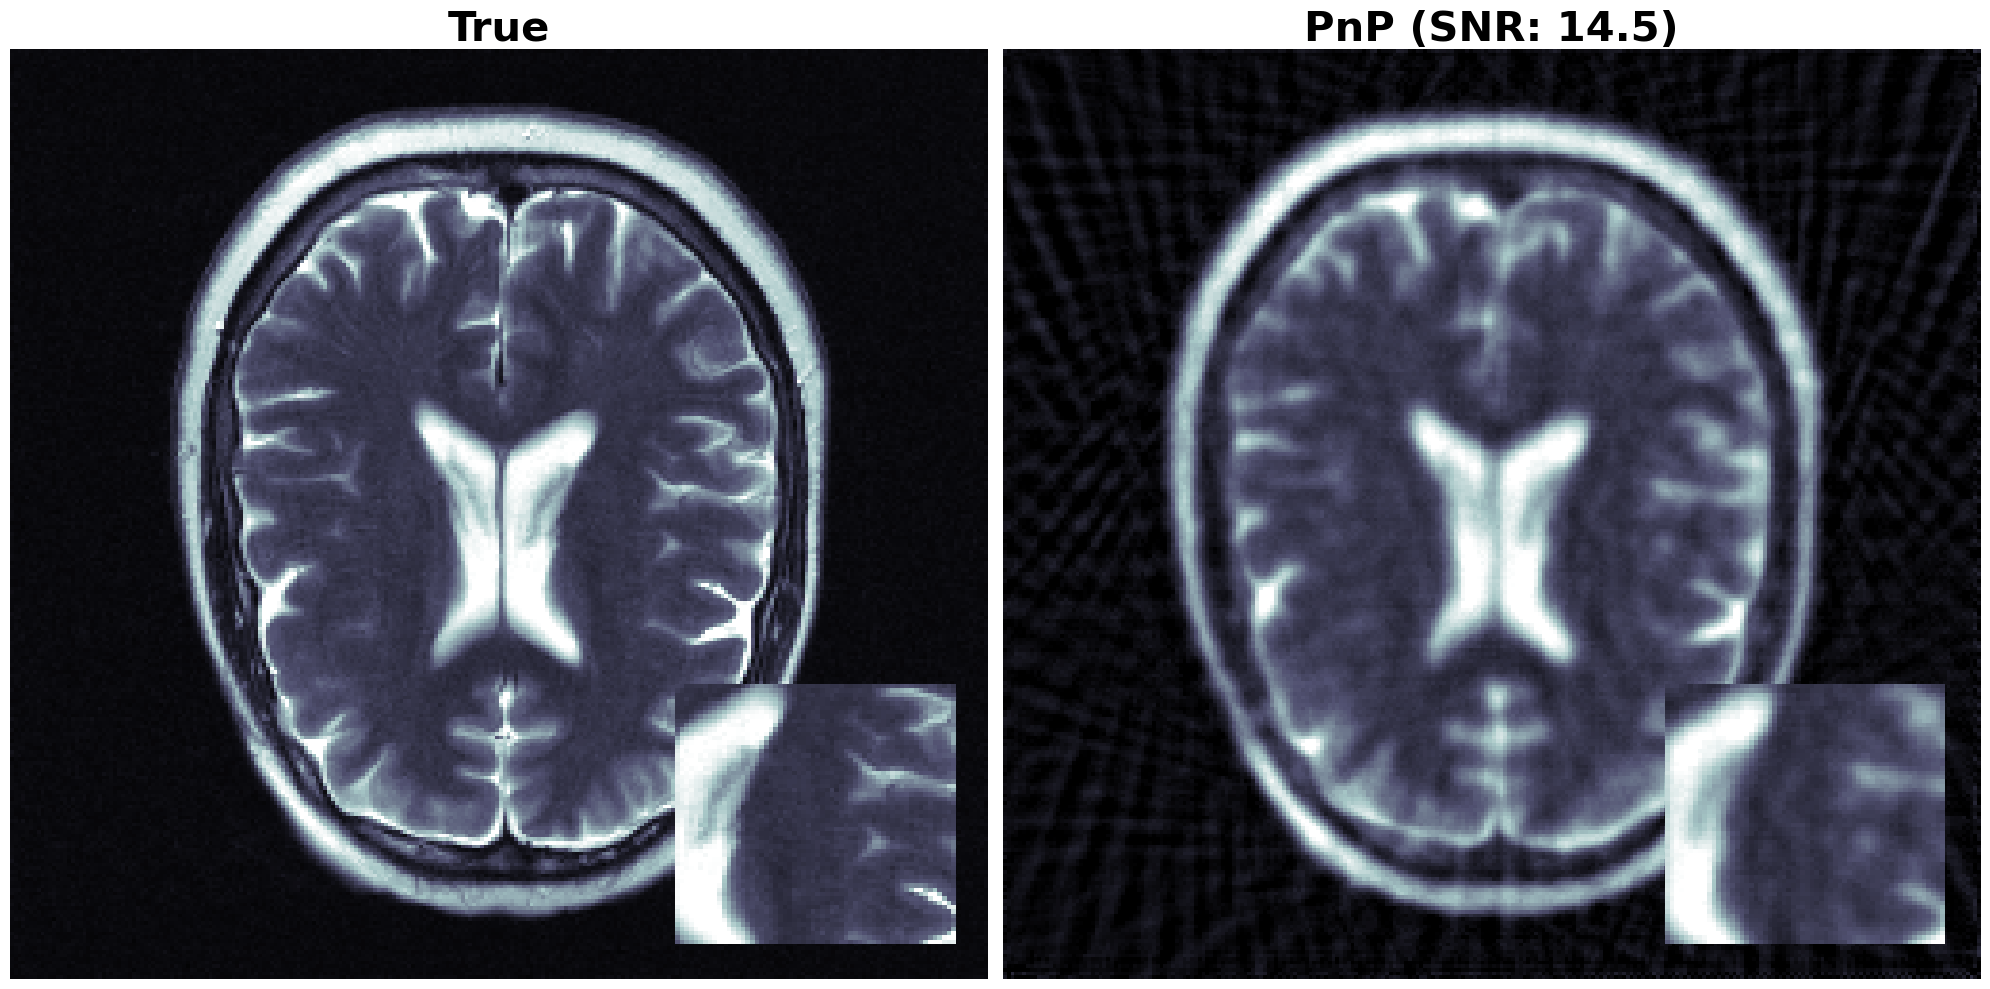

In [19]:
plt_comparison(brain, brainpnp, cmap='bone', clim=(0, 0.7), 
               titles=['True', 'PnP'], zoom=(100, 160, 130, 190),
               metricname='SNR', metric=snr)